# Deep Learning aplicado a un guión de película

In [1]:
import pandas as pd

## Importación del guión a Df

In [2]:
# Leer el archivo CSV
df = pd.read_csv("subtitulos.csv", encoding="utf-8")

In [3]:
# Mostrar todo el contenido en varias filas para cada columna
pd.set_option('display.max_colwidth', None)
df.sample(5)

,inicio,fin,subtitulo
324,"00:18:24,854","00:18:26,147",MAN [DUBBED]: Jerry Maguire.
710,"00:41:09,885","00:41:12,638","JERRY: Cush, how are you, man?"
1280,"01:17:13,254","01:17:16,758","I'll be back in just a second, okay?"
1666,"01:47:36,618","01:47:39,245","-Now? ROD: Baby, baby, baby now!"
1866,"02:02:02,858 --> 02:02:04,401 And he is getting up.",NaN,NaN


In [4]:
df.shape

(2028, 3)

## NLP

In [5]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

In [6]:
# Cargar modelo
# ver otros como: es_core_news_sm, es_core_news_md, es_core_news_lg
nlp = spacy.load("en_core_web_sm")

### Limpieza

In [7]:
# Eliminar filas donde 'subtitulo' es NaN
df = df.dropna(subset=['subtitulo'])

Función de limpieza total que deja el contenido en minúsculas y sin puntuación

In [8]:
# Función para limpiar el texto: convertir a minúsculas y eliminar puntuación
def limpiar_texto1(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar signos de puntuación
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

Función de limpieza parcial que deja el contenido en minúsculas y sin puntuación salvo '?%¿!¡'

In [9]:
import re

def limpiar_texto2(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar caracteres no deseados pero mantener '?%¿!¡'
    texto = re.sub(r'[^\w\s?%¿!¡]', '', texto)
    # Eliminar espacios redundantes
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

El campo: **subtituloLimpio1** se utilizará para toquenizar

In [10]:
# Aplicar limpieza al subtítulo
df['subtituloLimpio1'] = df['subtitulo'].apply(limpiar_texto1)

El campo: **subtituloLimpio2** se utilizará para análisis de sentimiento por conservar los signos '?' y '!' que permiten interpretar mejor el sentimiento del texto.

In [11]:
# Aplicar limpieza al subtítulo
df['subtituloLimpio2'] = df['subtitulo'].apply(limpiar_texto2)

### Tokenización

Analizando los resultados hasta aquí, veo ejemplos donde la tokenización falla desde mi punto de vista:
- **I didn't -> [i, did, nt]**

Por lo anterior, decidí expandir primero las contracciones y luego realizar la tokenización.

In [12]:
import contractions

def expandir_contracciones(texto):
    return contractions.fix(texto)

# Expande contracciones antes de tokenizar
df["subtituloExp"] = df["subtituloLimpio1"].apply(expandir_contracciones)

Tokenizo los subtítulos en una nueva columna 'tokens'. Recordemos que el campo: **subtituloLimpio1** se utilizará para toquenizar

In [13]:
# Tokenizar cada subtítulo usando SpaCy
df["tokens"] = df["subtituloExp"].apply(lambda text: [token.text for token in nlp(text)])

In [14]:
# Contar las filas donde hay tokens en blanco o vacíos
casos_con_tokens_vacios = df['tokens'].apply(lambda x: any(token.strip() == "" for token in x)).sum()

print(f"Casos con tokens vacíos o en blanco: {casos_con_tokens_vacios}")

Casos con tokens vacíos o en blanco: 79


In [15]:
# Limpieza de tokens en blanco
df['tokens'] = df['tokens'].apply(lambda x: [token for token in x if token.strip() != ""])

Comparamos los resultados de los tratamientos realizados:

In [16]:
df[['subtitulo','subtituloExp','tokens']].sample(5)

,subtitulo,subtituloExp,tokens
1961,"It's a contract, guaranteed. Arizona Cardinals. Four years.",its a contract guaranteed arizona cardinals four years,"[its, a, contract, guaranteed, arizona, cardinals, four, years]"
424,I'm gonna make this decision easy for you.,i am going to make this decision easy for you,"[i, am, going, to, make, this, decision, easy, for, you]"
1682,"Jerry, can I come in and watch TV?",jerry can i come in and watch tv,"[jerry, can, i, come, in, and, watch, tv]"
1061,Do not worry about your future.,do not worry about your future,"[do, not, worry, about, your, future]"
1972,"You're militant, but I ain't mad at you. Nothing but love for you.",you are militant but i are not mad at you nothing but love for you,"[you, are, militant, but, i, are, not, mad, at, you, nothing, but, love, for, you]"


### Sin Stopwords

Genero columna 'tokensSinStopwords'

In [17]:
# Eliminar stopwords de los tokens
df["tokensSinStopwords"] = df["tokens"].apply(lambda tokens: [token for token in tokens if not nlp.vocab[token].is_stop])

In [18]:
df[["subtitulo", "tokens","tokensSinStopwords"]].sample(5)

,subtitulo,tokens,tokensSinStopwords
180,"Hi, my son is really allergic to the material in the blankets.","[hi, my, son, is, really, allergic, to, the, material, in, the, blankets]","[hi, son, allergic, material, blankets]"
1610,Huh?,[huh],[huh]
1428,"...surviving, splendid black man.","[surviving, splendid, black, man]","[surviving, splendid, black, man]"
614,That's wonderful. Next time you lecture me...,"[that, is, wonderful, next, time, you, lecture, me]","[wonderful, time, lecture]"
542,"Congratulations, you're still my agent.","[congratulations, you, are, still, my, agent]","[congratulations, agent]"


### Lematización

Aplico lematización para generar una nueva columna: tokensLematizados

In [19]:
# Lematizar los tokens sin stopwords
df["tokensLematizados"] = df["tokensSinStopwords"].apply(lambda tokens: [nlp(token)[0].lemma_ for token in tokens])

In [20]:
df[["subtitulo", "tokens","tokensSinStopwords","tokensLematizados"]].sample(5)

,subtitulo,tokens,tokensSinStopwords,tokensLematizados
81,Wait.,[wait],[wait],[wait]
26,JERRY: I'm the guy you don't usually see.,"[jerry, i, am, the, guy, you, do, not, usually, see]","[jerry, guy, usually]","[jerry, guy, usually]"
607,-What about medical? -Of course medical.,"[what, about, medical, of, course, medical]","[medical, course, medical]","[medical, course, medical]"
1614,She was loyal.,"[she, was, loyal]",[loyal],[loyal]
844,We signed an hour ago.,"[we, signed, an, hour, ago]","[signed, hour, ago]","[sign, hour, ago]"


## Análisis de Sentimiento

Genero campo 'subtitulo_es' para mejor interpretación de algunos resultados.

In [24]:
from google.cloud import translate_v2 as translate
import os

# Configura la clave del servicio
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'traductor-448217-8995a2d825d7.json'

# Inicializar cliente de traducción
translate_client = translate.Client()

# Función para traducir texto
def traducir_texto_google(text):
    try:
        if text:  # Verificar que el texto no sea vacío o None
            result = translate_client.translate(text, target_language='es')
            return result['translatedText']
        return None
    except Exception as e:
        print(f"Error al traducir: {text}. Detalle: {e}")
        return None


In [25]:
# Aplicar la traducción a los subtítulos
df['subtitulo_es'] = df['subtituloLimpio2'].apply(traducir_texto_google)

In [148]:
df[['subtitulo','subtitulo_es']].sample(5)

,subtitulo,subtitulo_es
106,JERRY: I couldn't escape one simple thought:,JERRY: No pude escapar de un simple pensamiento:
1992,Did you see?,¿Has visto?
1347,-Just tell me one thing. -No.,-Sólo dime una cosa. -No.
736,"-Let's do it. JERRY: Hi, Mel. How are you?","-Hagámoslo. JERRY: Hola, Mel. ¿Cómo estás?"
1200,Exactly.,Exactamente.


### TextBlob

In [27]:
from textblob import TextBlob

# Función para obtener la polaridad del sentimiento
def sentimientoTextblob(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Devuelve el puntaje de polaridad (-1 a 1)

In [28]:
# Aplicar el análisis de sentimiento a los subtítulos originales
df['sentimiento'] = df['subtituloLimpio2'].apply(sentimientoTextblob)

In [147]:
df[["subtitulo","subtituloLimpio2", "sentimiento", "subtitulo_es"]].sample(5)

,subtitulo,subtituloLimpio2,sentimiento,subtitulo_es
156,"-They've all gone out. -Oh, they did?",theyve all gone out oh they did?,0.000000,"-Todos se fueron. -¿Oh, lo hicieron?"
144,"That's how you become great, man.",thats how you become great man,0.800000,"Así es como te vuelves grande, hombre."
1207,"The guy's a loser so I broke up with him, and then he started stalking me.",the guys a loser so i broke up with him and then he started stalking me,0.000000,"El tipo es un perdedor, así que rompí con él y luego comenzó a acosarme."
1932,"And now, I just...",and now i just,0.000000,"Y ahora, yo solo..."
1494,All right. Goodbye.,all right goodbye,0.285714,Está bien. Adiós.


In [32]:
df[["sentimiento"]].describe()

,sentimiento
count,1995.000000
mean,0.068777
std,0.262137
min,-1.000000
25%,0.000000
50%,0.000000
75%,0.096875
max,1.000000


**Vemos que los sentimientos recorren todo el espectro disponible. También podemos considerar que el guión de la película es medianamente más positivo que neutro observando la media del análisis.**

### Análisis de Sentimiento con VADER

Buscando otro método que quizás me realice una mejor clasificación de sentimientos es que voy a probar VADER.

In [33]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Asegúrate de que los datos necesarios estén descargados
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jorge\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [34]:
sia = SentimentIntensityAnalyzer()

def sentimiento_vader(text):
    scores = sia.polarity_scores(text)
    return scores['compound']  # Devuelve el puntaje general de sentimiento

df['sentimientoVader'] = df['subtituloLimpio2'].apply(sentimiento_vader)

In [38]:
df[[ "subtitulo",'subtituloLimpio2','sentimientoVader', "subtitulo_es"]].sample(5)

,subtitulo,subtituloLimpio2,sentimientoVader,subtitulo_es
314,"-Got you! Ha, ha! -Good to see you, buddy.",got you! ha ha! good to see you buddy,0.8065,"-¡Te tengo! ¡Ja, ja! -Me alegro de verte, amigo."
1536,"MAN: Get down, Ray!",man get down ray!,0.0000,"HOMBRE: ¡Abajo, Ray!"
1025,ROD: Seventy-two percent of new buyers are African-American.,rod seventytwo percent of new buyers are africanamerican,0.0000,ROD: El setenta y dos por ciento de los nuevos compradores son afroamericanos.
1509,"Look, if this weekend should turn into next month...",look if this weekend should turn into next month,0.0000,"Mira, si este fin de semana se convirtiera en el próximo mes..."
38,You and I both know there's a number you can afford.,you and i both know theres a number you can afford,0.0772,Tú y yo sabemos que hay una cantidad que puedes permitirte.


In [39]:
df['sentimientoVader'].describe()

count    1995.000000
mean        0.092346
std         0.342935
min        -0.900100
25%         0.000000
50%         0.000000
75%         0.340000
max         0.931200
Name: sentimientoVader, dtype: float64

**Parece capturar de buena manera el sentimiento dentro de los subtítulos con VADER.**
La media indica que es un texto levemente positivo en general.

#### Top de Positivos y Negativos

In [161]:
# Obtener los 10 subtítulos más positivos
top_positivos = df.nlargest(10, 'sentimientoVader')[['sentimientoVader', 'subtitulo', 'subtitulo_es']]

# Obtener los 10 subtítulos más negativos
top_negativos = df.nsmallest(10, 'sentimientoVader')[['sentimientoVader', 'subtitulo', 'subtitulo_es']]

In [162]:
# Mostrar resultados
print("Subtítulos más positivos:")
top_positivos

Subtítulos más positivos:


,sentimientoVader,subtitulo,subtitulo_es
834,0.9312,-I love my son. -I love your son. I love your son!,-Amo a mi hijo. -Amo a tu hijo. ¡Amo a tu hijo!
2003,0.9274,"But I love my wife, I love my life...","Pero amo a mi esposa, amo mi vida..."
1183,0.9246,-He said you'd be happy-- Glad. -Did he say happy or glad?,-Dijo que estarías feliz-- Contento. -¿Dijo feliz o contento?
1996,0.9209,"...but if he's got natural talent, pure joy for the game....","...pero si tiene talento natural, pura alegría por el juego...."
1185,0.9186,-Glad is good. Glad is good. -Yeah.,-Me alegro es bueno. Me alegro es bueno. -Sí.
1578,0.9169,I've got a great team behind me and I'm loving it. I'm loving life.,Tengo un gran equipo detrás de mí y me encanta. Me encanta la vida.
1568,0.9149,RAY: Yay! Yay! -We're gonna have a great season!,RAY: ¡Sí! ¡Sí! ¡Vamos a tener una gran temporada!
1968,0.8827,I love everybody. I love my wife! Whoo! Marcee!,Amo a todos. Amo a mi esposa. ¡Guau! ¡Marcee!
508,0.8765,"But I like you. Yes, I like you.","Pero me gustas. Sí, me gustas."
308,0.8720,"Calm down, relax, act surprised, and have an amazing time.","Cálmate, relájate, actúa sorprendido y pasatelo increíble."


In [163]:
print("\nSubtítulos más negativos:")
top_negativos


Subtítulos más negativos:


,sentimientoVader,subtitulo,subtitulo_es
1549,-0.9001,"You fuck this up, I'll kill you.","Si la cagas, te mato."
540,-0.8883,-Who's your motherfucker? -You're my motherfucker!,-¿Quién es tu hijo de puta? -¡Eres mi hijo de puta!
1412,-0.8883,"Broke! Broke, broke, broke.","¡Se rompió! Se rompió, se rompió, se rompió."
483,-0.8860,"I will kill for you, maim for you. I will rape and pillage for you.","Mataré por ti, mutilaré por ti, violaré y saquearé por ti."
340,-0.8807,"Lies, lies, lies. He's an agent. He lies.","Mentiras, mentiras, mentiras. Es un agente. Miente."
1831,-0.8289,Can't you be loyal to your brother? Get the hell out of my house! Get out!,¿No puedes ser leal a tu hermano? ¡Sal de mi casa! ¡Fuera!
149,-0.8236,They don't want peace and they're not capable of love.,No quieren la paz y no son capaces de amar.
1957,-0.8126,Your brother loses a leg in a tragic bass-fishing accident.,Tu hermano pierde una pierna en un trágico accidente de pesca de lubina.
919,-0.8086,"I don't want to hear your ""Nah, nah, nah. Oh, I lost Cush and Avery"" and shit.","No quiero oír tus No, no, no. Perdí a Cush y Avery y esas cosas."
1647,-0.8019,But he keeps a brother-- I ain't get no respect. This is bullshit.,Pero él tiene un hermano... No me respetan. Esto es una tontería.


### Análisis con TF-IDF vectorizer

In [164]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Obtener stopwords en inglés
stop_words_en = stopwords.words('english')
stop_words = set(stop_words_en)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defino funciones de limpieza específicas para asegurar la ejecución de las tareas que siguen a continuación.

In [167]:
def limpiar_texto3(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar signos de puntuación (sin dejar ninguno)
    text = re.sub(r'[^\w\s]', '', text)
    return text

def eliminar_stopwords(text):
    # Tokenizar usando spaCy
    tokens = nlp(text)
    # Filtrar stopwords
    filtered_tokens = [token.text for token in tokens if token.text not in stop_words]
    return " ".join(filtered_tokens)

def lematizar_texto1(text):
    # Tokenizar y lematizar usando spaCy
    tokens = nlp(text)
    lematizado = [token.lemma_ for token in tokens]
    return " ".join(lematizado)

def lematizar_texto(text):
    # Tokenizar y lematizar usando el modelo spaCy en español
    doc = nlp(text)
    # Devolver lemas uniendo las palabras
    return " ".join([token.lemma_ for token in doc if not token.is_punct])

In [168]:
# Crear la columna subtitulolimpio3
df['subtitulolimpio3'] = df['subtitulo'].apply(limpiar_texto3)

In [169]:
df[['subtitulo', 'subtitulolimpio3']].sample(5)

,subtitulo,subtitulolimpio3
1788,Split to the right. Swenson looks that way.,split to the right swenson looks that way
840,"You didn't sign anything with Sugar, right?",you didnt sign anything with sugar right
1070,...drunk.,drunk
123,The way a stadium sounds...,the way a stadium sounds
272,To drive us all the way out to Manhattan Beach.,to drive us all the way out to manhattan beach


Con las funciones anteriores creo el campo 'subtituloSinStopwords1' apropiado para TF-IDF

In [170]:
# Eliminar stopwords
df['subtituloSinStopwords1'] = df['subtitulolimpio3'].apply(eliminar_stopwords)

In [171]:
df[['subtitulo', 'subtitulolimpio3','subtituloSinStopwords1']].sample(10)

,subtitulo,subtitulolimpio3,subtituloSinStopwords1
1926,"Okay, okay.",okay okay,okay okay
782,"...makes me love you, baby. You know?",makes me love you baby you know,makes love baby know
801,They've been calling all night long.,theyve been calling all night long,calling night long
1619,It's not sexy. Shit! But that's an answer.,its not sexy shit but thats an answer,sexy shit answer
390,"You said fewer clients, you put it all down on paper. Jesus Christ.",you said fewer clients you put it all down on paper jesus christ,said fewer clients put paper jesus christ
319,Everybody loves you.,everybody loves you,everybody loves
561,...real and fun and inspiring...,real and fun and inspiring,real fun inspiring
1578,I've got a great team behind me and I'm loving it. I'm loving life.,ive got a great team behind me and im loving it im loving life,got great team behind loving loving life
1805,ALL: Break!,all break,break
697,[BOTH LAUGHING],both laughing,laughing


Creo el campo 'subtituloSinSWLematizado1' apropiado para TF-IDF.

In [172]:
# Lematizar
df['subtituloSinSWLematizado1'] = df['subtituloSinStopwords1'].apply(lematizar_texto)

In [173]:
df[['subtitulo', 'subtitulolimpio3','subtituloSinStopwords1','subtituloSinSWLematizado1']].sample(10)

,subtitulo,subtitulolimpio3,subtituloSinStopwords1,subtituloSinSWLematizado1
665,I'm free fallin',im free fallin,free fallin,free fallin
1767,Going for a second consecutive Super Bowl.,going for a second consecutive super bowl,going second consecutive super bowl,go second consecutive super bowl
1110,[WHISTLE BLOWS],whistle blows,whistle blows,whistle blow
457,you know I'd go with you.,you know id go with you,know go,know go
1832,Hello? Hold on. It's Jerry Maguire.,hello hold on its jerry maguire,hello hold jerry maguire,hello hold jerry maguire
1615,"I mean, you know, everything grew from there.",i mean you know everything grew from there,mean know everything grew,mean know everything grow
920,"Could I have another drink, please? Could I--?",could i have another drink please could i,could another drink please could,could another drink please could
923,"And if I got to ride your ass like Zorro, you gonna show me the money.",and if i got to ride your ass like zorro you gonna show me the money,got ride ass like zorro gon na show money,get ride ass like zorro go to show money
1571,[WHISTLE BLOWS],whistle blows,whistle blows,whistle blow
1711,And at least I can do something about it now.,and at least i can do something about it now,least something,least something


In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Inicializar el vectorizador TF-IDF
tfidf = TfidfVectorizer(stop_words=stop_words_en, max_features=500)

# Generar la matriz TF-IDF
tfidf_matrix = tfidf.fit_transform(df['subtitulolimpio3'])

In [175]:
# Convertir la matriz en un DataFrame para inspección
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

In [176]:
# Mostrar las primeras filas del DataFrame resultante
tfidf_df.sample(5)

,10,across,act,actually,afford,agent,agents,ago,aint,almost,...,wrote,yeah,year,years,yes,yet,youll,youre,youve,zoo
1542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [177]:
# Calcular los puntajes promedio de cada palabra en todas las filas
tfidf_scores = tfidf_df.mean().sort_values(ascending=False)

# Mostrar las 10 palabras más relevantes según TF-IDF
print("Palabras más relevantes:")
print(tfidf_scores.head(10))

Palabras más relevantes:
jerry    0.030698
im       0.028223
know     0.025141
dont     0.019416
oh       0.018792
rod      0.016891
right    0.016742
love     0.016336
man      0.016078
okay     0.015326
dtype: float64


In [179]:
# Agregar la suma de TF-IDF de cada subtítulo como una métrica adicional
df['tfidf_sum'] = tfidf_df.sum(axis=1)

In [180]:
# Combinar con sentimiento
df[['subtitulo', 'subtitulo_es','sentimientoVader', 'tfidf_sum']].sort_values('sentimientoVader', ascending=False).head(10)

,subtitulo,subtitulo_es,sentimientoVader,tfidf_sum
834,-I love my son. -I love your son. I love your son!,-Amo a mi hijo. -Amo a tu hijo. ¡Amo a tu hijo!,0.9312,0.000000
2003,"But I love my wife, I love my life...","Pero amo a mi esposa, amo mi vida...",0.9274,NaN
1183,-He said you'd be happy-- Glad. -Did he say happy or glad?,-Dijo que estarías feliz-- Contento. -¿Dijo feliz o contento?,0.9246,1.385197
1996,"...but if he's got natural talent, pure joy for the game....","...pero si tiene talento natural, pura alegría por el juego....",0.9209,NaN
1185,-Glad is good. Glad is good. -Yeah.,-Me alegro es bueno. Me alegro es bueno. -Sí.,0.9186,1.000000
1578,I've got a great team behind me and I'm loving it. I'm loving life.,Tengo un gran equipo detrás de mí y me encanta. Me encanta la vida.,0.9169,2.806916
1568,RAY: Yay! Yay! -We're gonna have a great season!,RAY: ¡Sí! ¡Sí! ¡Vamos a tener una gran temporada!,0.9149,1.401470
1968,I love everybody. I love my wife! Whoo! Marcee!,Amo a todos. Amo a mi esposa. ¡Guau! ¡Marcee!,0.8827,2.426084
508,"But I like you. Yes, I like you.","Pero me gustas. Sí, me gustas.",0.8765,1.414214
850,"""Soothe me, save me, love me.""","Tranquilízame, sálvame, ámame.",0.8720,1.408841


Veamos la frecuencia con que aparecen los subtítulos según su 'tfidf_sum', que es la suma de TF-IDF para el subtítulo evaluado.

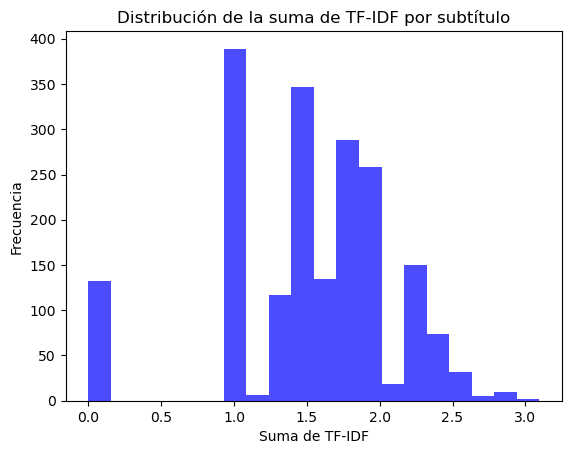

In [181]:
import matplotlib.pyplot as plt

plt.hist(df['tfidf_sum'], bins=20, color='blue', alpha=0.7)
plt.title('Distribución de la suma de TF-IDF por subtítulo')
plt.xlabel('Suma de TF-IDF')
plt.ylabel('Frecuencia')

plt.show()

Podemos separar subtítulos en rangos de TF-IDF y observar algunos para entender como se plasma esa diferencia en el índice.

In [182]:
threshold=1.5
subtitulos_altos = df[df['tfidf_sum'] > threshold]
subtitulos_bajos = df[df['tfidf_sum'] < threshold]

In [184]:
print('subtitulos_altos:')
subtitulos_altos[['subtitulo','subtitulo_es','tfidf_sum']].sample(5)

subtitulos_altos:


,subtitulo,subtitulo_es,tfidf_sum
1363,"Well, I don't know if you're interested in this one little detail.","Bueno, no sé si te interesa este pequeño detalle.",2.432761
32,"-Well. thanks. -You're welcome, Johnny.","-Bueno, gracias. -De nada, Johnny.",2.329976
1024,Yeah? Thanks.,¿Si? Gracias.,1.529795
502,"And I'm supposed to be a superstar, man!","¡Y se supone que soy una superestrella, hombre!",2.201807
1025,ROD: Seventy-two percent of new buyers are African-American.,ROD: El setenta y dos por ciento de los nuevos compradores son afroamericanos.,2.442440


Mi interpretación es que un alto TF-IDF resulta para subtítulos con gran valor de contenido impactante. Son como fraces que podemos recordar y asociar a la película.

In [185]:
print('subtitulos_bajos:')
subtitulos_bajos[['subtitulo','subtitulo_es','tfidf_sum']].sample(5)

subtitulos_bajos:


,subtitulo,subtitulo_es,tfidf_sum
713,"Man, my hand's getting tired.","Hombre, se me está cansando la mano.",0.0
1207,"The guy's a loser so I broke up with him, and then he started stalking me.","El tipo es un perdedor, así que rompí con él y luego comenzó a acosarme.",1.0
1113,I know you wouldn't do that to a friend.,Sé que no le harías eso a un amigo.,1.0
1413,-I'm not as good at the insults as she is. -No. That was pretty good.,-No soy tan buena con los insultos como ella. -No. Eso estuvo bastante bien.,1.0
1125,I introduced you to your wife. We've spent Christmases together.,Te presenté a tu esposa. Hemos pasado las Navidades juntos.,1.0


Para un bajo TF-IDF es todo lo contrario, en general son fraces menos impactantes.

En el siguiente gráfico se representa el eje x coincidente con el gráfico anterior pero en el se plasma la evaluación de sentimientos resultante.
De ésta manera se puede tener una visión general de como se distribuye el sentimiento en toda la película.

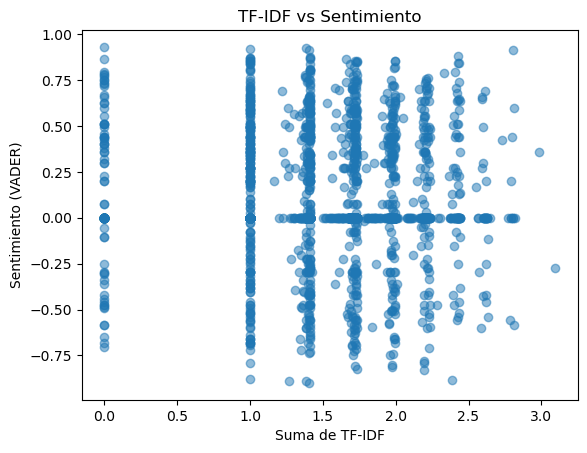

In [186]:
plt.scatter(df['tfidf_sum'], df['sentimientoVader'], alpha=0.5)
plt.title('TF-IDF vs Sentimiento')
plt.xlabel('Suma de TF-IDF')
plt.ylabel('Sentimiento (VADER)')
plt.show()

### Nube de Palabras

In [187]:
X = tfidf.fit_transform(df['subtituloLimpio1'])

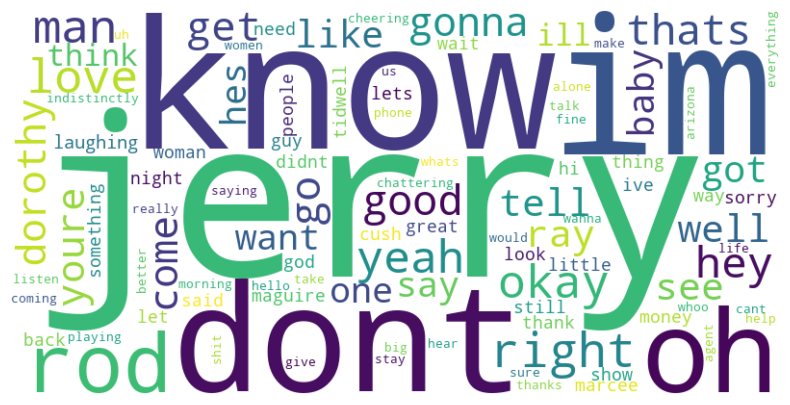

In [188]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Obtener las palabras y sus puntuaciones TF-IDF
# Aquí estamos utilizando el atributo `get_feature_names_out()` que te da las palabras,
# y el atributo `toarray()` para obtener las puntuaciones de TF-IDF
words = tfidf.get_feature_names_out()
tfidf_scores = X.sum(axis=0).A1  # Sumar las puntuaciones de cada palabra

# Crear un diccionario de palabras con sus correspondientes puntuaciones
word_dict = dict(zip(words, tfidf_scores))

# Generar la nube de palabras con las palabras y puntuaciones obtenidas
#wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)
# Generar la nube de palabras con algunas opciones de personalización
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, colormap='viridis').generate_from_frequencies(word_dict)

# Visualizar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Ocultar los ejes
plt.show()